In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from typing_extensions import List, TypedDict
from langgraph.graph import StateGraph

class AgentState(TypedDict):
    query: str #질문
    context: list
    answer: str

graph_builder = StateGraph(AgentState)

In [3]:
from langchain_community.tools import TavilySearchResults

tavily_search_tool = TavilySearchResults(
    max_results = 3, 
    search_engine="advanced",
    include_ansers = True,
    include_raw_content = True,
    include_imagaes = True
)

In [4]:
#웹 검색
def web_search(state: AgentState) -> AgentState:
    """
    주어진 state를 기반으로 웹 검색을 수행합니다.
    
    Args:
        state (AgentState): 사용자의 질문을 포함한 에이전트의 현재 state

    Returns:
        AgentState: 웹 검색 결과가 추가된 state를 반환합니다.    
    """

    query = state["query"]
    results = tavily_search_tool.invoke(query)

    return {'context': results}

In [5]:
from langchain import hub
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser

generate_prompt = hub.pull('rlm/rag-prompt')
generate_llm = ChatOpenAI(model = 'gpt-4o')

def web_generate(state: AgentState) -> AgentState:
    """
    주어진 문맥과 질문을 기반으로 답변을 생성합니다.

    Args:
        state (AgentState): 문맥과 질문을 포함한 에이전트의 현재 state

    Returns:
        AgentState: 생성된 답변을 포함한 state를 반환합니다.   
    """

    context = state['context']
    query = state['query']

    rag_chain = generate_prompt | generate_llm | StrOutputParser()
    response = rag_chain.invoke({'context': context, 'question': query})

    return{'answer': response}

d:\edu_data\AI_prompt\workspace\ai_agent_work2\langgraph_uv\.venv\Lib\site-packages\langsmith\client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [6]:
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser

#llm 생성

basic_llm = ChatOpenAI(model = 'gpt-4o-mini')

def basic_generate(state: AgentState) -> AgentState:
    """
    사용자의 질문에 기반하여 기본 답변을 생성합니다.

    Args:
        state (AgentState): 문맥과 질문을 포함한 에이전트의 현재 state

    Returns:
        AgentState: 생성된 답변을 포함한 state를 반환합니다.   
    """
    query = state['query']

    llm_response = basic_llm.invoke(query)

    return{'answer': llm_response}

In [7]:
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from typing import Literal
#라우팅한 결과값을 하나의 객체화
#agent와 상관없음
#라우터는 노드가 아님

class Route(BaseModel):
    target: Literal['vector_store', 'llm', 'web_search'] = Field( #Route 객체 안에 target 속성. 그리고 그 안에 3개의 속성 리턴하도록 만듦
        description="The target for the query to answer"
    )

router_system_prompt = """
You are an expert at routing a user's question to 'vector_store', 'llm', or 'web_search'.
'vector_store' contains information about income tax up to December 2024.
if you think the question is simple enough use 'llm'
if you think you need to search the web to answer the question use 'web_search'
"""


router_prompt = ChatPromptTemplate.from_messages([
    ("system", router_system_prompt),
    ("human", "{query}")
])

router_llm = ChatOpenAI(model='gpt-4o-mini')
structed_router_llm = router_llm.with_structured_output(Route) #Route 객체로 리턴하기로 약속

def router(state: AgentState) -> Literal['vector_store', 'llm', 'web_search']:
    """
    사용자의 질문을 기반으로 적절한 경로를 결정합니다.

    Args:
        state (AgentState): 사용자의 질문을 포함한 에이전트의 현재 state.

    Returns:
        Literal['vector_store', 'llm', 'web_search']:
        질문을 처리하기 위한 적절한 경로를 나타내는 문자열을 반환한다.
    """
    query = state['query']

    router_chain = router_prompt | structed_router_llm

    route = router_chain.invoke({"query": query})
    #라우터에 질의하면 'vector_store', 'llm', 'web_search' 이 셋 중 하나 리턴

    return route.target


In [8]:
from income_tax_graph import graph as income_tax_subgraph

graph_builder.add_node('income_tax_agent', income_tax_subgraph)
graph_builder.add_node('web_search', web_search)
graph_builder.add_node('web_generate', web_generate)
graph_builder.add_node('basic_generate', basic_generate)

d:\edu_data\AI_prompt\workspace\ai_agent_work2\langgraph_uv\.venv\Lib\site-packages\langsmith\client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(
d:\edu_data\AI_prompt\workspace\ai_agent_work2\langgraph_uv\.venv\Lib\site-packages\langsmith\client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(
d:\edu_data\AI_prompt\workspace\ai_agent_work2\langgraph_uv\.venv\Lib\site-packages\langsmith\client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [9]:
from langgraph.graph import START, END

graph_builder.add_conditional_edges(
    START,
    router, #라우터를 만나면 각각의 노드의 이름이 호출
    {
        'vector_store': 'income_tax_agent',
        'llm': 'basic_generate',
        'web_search': 'web_search'
    }
)

graph_builder.add_edge('web_search', 'web_generate')
graph_builder.add_edge('web_search', END)
graph_builder.add_edge('web_generate', END)
graph_builder.add_edge('basic_generate', END)

In [10]:
graph = graph_builder.compile()

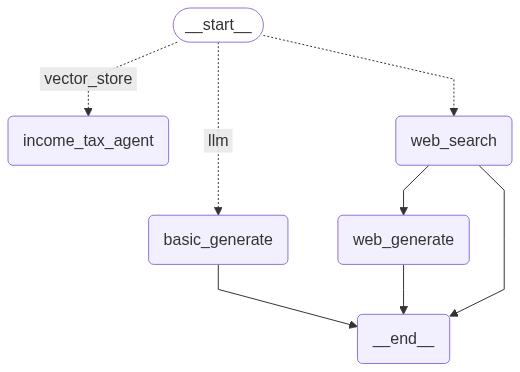

In [11]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [12]:
initial_state = {'query': '대한민국 수도는 어디인가요?'}
graph.invoke(initial_state)

{'query': '대한민국 수도는 어디인가요?',
 'answer': AIMessage(content='대한민국의 수도는 서울입니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 8, 'prompt_tokens': 15, 'total_tokens': 23, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'finish_reason': 'stop', 'logprobs': None}, id='run--bd45f0d8-3934-47c2-b115-e7d568711ab8-0', usage_metadata={'input_tokens': 15, 'output_tokens': 8, 'total_tokens': 23, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})}

In [13]:
initial_state = {'query': '경찰병원역 맛집을 추천해 주세요?'}
graph.invoke(initial_state)

{'query': '경찰병원역 맛집을 추천해 주세요?',
 'context': [{'url': 'https://www.diningcode.com/list.dc?query=%EA%B2%BD%EC%B0%B0%EB%B3%91%EC%9B%90%EC%97%AD',
   'content': '경찰병원역맛집 (269곳) · 1. 함경도 찹쌀순대 가락시장 · 2. 오향가 가락동 · 3. 우불식당 가락시장 · 4. 냠냠물고기 가락동 · 5. 진성한우곱창 가락동 · 6. 삼청각'},
  {'url': 'https://hotel-iu.tistory.com/4984',
   'content': "Published Time: 2024-09-02T07:41:43+09:00\n\n경찰병원역 맛집 베스트 추천 top 10\n\n===============\n\n코니코니 해피라이프\n========================================================\n\n   홈\n\n추천 TOP 10\n\n경찰병원역 맛집 베스트 추천 top 10\n----------------------\n\n코니코니 2024. 9. 2. 07:41\n\n반응형\n\n#### 경찰병원역 맛집 베스트 추천 top 10\n\n  \n\n경찰병원역 맛집 베스트 추천 top 10곳을 소개합니다.\n\n  \n\n1: 취영루 송파점\nImage 1\n상호명: 취영루 송파점\n\n주소: 서울특별시 송파구 가락동 120-1 1, 2층 취영루\n\n전화번호: 미입력\n\n관련 키워드: ['송파상견례', '송파돌잔치', '송파룸식당', '송파회식', '송파룸대관']\n\n관련 태그: ['데이트하기 좋은', '모임하기 좋은', '단체회식'] [...] 영업시간: 매일 10:00~22:30 | 일요일 휴무\n소개글: 안녕하세요 행복을 전하는 중국가정식 전문 밥향기입니다. 사장님이 직접 요리하시고 마라소스도 직접 만들어서 사용하기에 건강가정식입니다\n\n밥향기 바로가기▲\n\n  \n\n7: 진대감 가락점\

In [14]:
initial_state = {'query': '연봉 5천만원 거주자의 소득세는 얼마인가요?'}
graph.invoke(initial_state)

관련성 : relevant
거짓말:  not hallucinated
유용성: helpful


{'query': '연봉 5천만원 거주자의 소득세는 얼마인가요?',
 'context': [Document(metadata={'source': './tax.docx'}, page_content='제55조(세율) ①거주자의 종합소득에 대한 소득세는 해당 연도의 종합소득과세표준에 다음의 세율을 적용하여 계산한 금액(이하 “종합소득산출세액”이라 한다)을 그 세액으로 한다. <개정 2014. 1. 1., 2016. 12. 20., 2017. 12. 19., 2020. 12. 29., 2022. 12. 31.>\n\n| 종합소득 과세표준          | 세율                                         |\n\n|-------------------|--------------------------------------------|\n\n| 1,400만원 이하     | 과세표준의 6퍼센트                             |\n\n| 1,400만원 초과     5,000만원 이하     | 84만원 + (1,400만원을 초과하는 금액의 15퍼센트)  |\n\n| 5,000만원 초과   8,800만원 이하     | 624만원 + (5,000만원을 초과하는 금액의 24퍼센트) |\n\n| 8,800만원 초과 1억5천만원 이하    | 3,706만원 + (8,800만원을 초과하는 금액의 35퍼센트)|\n\n| 1억5천만원 초과 3억원 이하         | 3,706만원 + (1억5천만원을 초과하는 금액의 38퍼센트)|\n\n| 3억원 초과    5억원 이하         | 9,406만원 + (3억원을 초과하는 금액의 38퍼센트)   |\n\n| 5억원 초과      10억원 이하        | 1억 7,406만원 + (5억원을 초과하는 금액의 42퍼센트)|\n\n| 10억원 초과        | 3억 8,406만원 + (10억원을 초과하는 금액의 45퍼센트)|\n\n\n\n\n\n② 거주자의 퇴직소득에 대한 소득세는 다음 